In [ ]:
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import minimize
from scipy.optimize import Bounds


In [ ]:
def simulate_unsubscriptions(n, p, T):
    '''
    Function to simulate the unsubscription journey for n costumers given a probability p of unsubcribing from the service. 
    p stays constant for the whole number of observation windows T.
    '''
    lost_list=[] #initiate a list to take notes about the number of users lost per step
    renewal_time=np.repeat(0,n) #initiate the array to take count of how many renewal the j-th client does.
    for i in range(T): 
        number_lost = np.random.binomial(n, p) # number of lost client per step
        lost_list.append(number_lost)
        renewal_time[sum(lost_list):] += 1 # +1 for each customer keeping his subscription at the i-th tiem window
        n -= number_lost # update the number of clients alive in the next step
    np.random.shuffle(renewal_time) #shuffle the results, avoid the clients being ordered by theier survival time
    return renewal_time

def simulate_unsubscriptions_geom(n, p, T):
    '''
    Function to simulate the unsubscription journey for n costumers given a probability p of unsubcribing from the service. 
    p stays constant for the whole number of observation windows T.

    Actually the model we want to build can be seen as a geometric distribution for the set n of clients with a probability p of success, 
    here the success represents the unsubsciption.
    '''
    unsubscriptions = np.random.geometric(p,n)-1 # draw n times from a geometric distribution with parameter p
    unsubscriptions[unsubscriptions>T] = T # cap the maximum occurence with the max observation time
    return unsubscriptions


In [ ]:
# run tests on running time

import time

num_runs = 100 # number of experiments
run_times_geom = [] # list of running time using geometric sampling
run_times_custom = [] # list of running time using custom simulation function

for i in range(num_runs):
    # take random parameter
    n = np.random.randint(5,500000)
    p = np.random.uniform()
    T = np.random.randint(2,200)

    # mesure the running time of the custom function
    start = time.time()
    renewal_time = simulate_unsubscriptions(n,p,T)
    end = time.time()
    run_times_custom.append(end - start)

    # mesure the running time of the geometric sampling
    start_geom = time.time()
    renewal_time = simulate_unsubscriptions_geom(n,p,T)
    end_geom = time.time()
    run_times_geom.append(end_geom - start_geom)

print('Average run time - simulate_unsubscriptions: {}'.format(np.mean(run_times_custom)))
print('Average run time - simulate_unsubscriptions_geom: {}'.format(np.mean(run_times_geom)))

Average run time - simulate_unsubscriptions: 0.013531670570373536
Average run time - simulate_unsubscriptions_geom: 0.014759469032287597


In [ ]:
unique, counts = np.unique(renewal_time, return_counts=True)
grouped_renewal = pd.DataFrame(unique, columns=['renewals'])
grouped_renewal['T']=T
grouped_renewal['N']=counts
grouped_renewal

,renewals,T,N
0,1,20,2
1,2,20,1
2,3,20,1
3,5,20,1
4,7,20,1
5,12,20,1
6,14,20,1
7,15,20,1
8,20,20,1


In [ ]:
def mean_estimator(renewal_time, print_stats=False):
    '''
    Estimation of the unsubscription probability by mean.

    First and fast solution to estimate the parameter p. 
    Take the ratio of unsubscriptions per time window and average over the T time windows.
    '''
    if int(max(renewal_time))==0: # take into consideration all clients unsubscribing before first renewal
        return 1
    perc_list = []
    for i in range(int(max(renewal_time))): #for each time window untill the maximum observed
        perc = np.sum(renewal_time==i)/np.sum(renewal_time>=i) # ratio of unsubsciber
        perc_list.append(perc)
    
    mean_est = np.mean(perc_list) #take the average over the time windows
    if print_stats:
        print('mean_est={}'.format(mean_est))
        print('rse mean={}'.format(np.sqrt(np.square(p-mean_est))))
    return mean_est

def w_mean_estimator(renewal_time, print_stats=False):
    '''
    Estimation of the unsubscription probability by weighted mean.

    Tries to improve simple mean estimation.
    Take the ratio of unsubscriptions per time window and average over the T time windows giving each time window a weight proportional to its size.
    '''
    if int(max(renewal_time))==0:
        return 1
    perc_list = np.array([])
    prop_surv = np.array([])
    for i in range(int(max(renewal_time))):
        perc = sum(renewal_time==i)/sum(renewal_time>=i)
        perc_list = np.append(perc_list, perc)
        prop_surv = np.append(prop_surv, (sum(renewal_time>=i)/len(renewal_time))) # save the size of the population considered in the time window

    weight_list = prop_surv/np.sum(prop_surv) #normalize the weight
    stima_w_media = np.sum(perc_list*weight_list)
    if print_stats:
        print('stima media={}'.format(stima_w_media))
        print('rse media={}'.format(np.sqrt(np.square(p-stima_w_media))))
    return stima_w_media

def prob_max_estimate(renewal_time, T, param_init=0.5):
    '''
    Exploiting the probability function of the phenomena to estimate the maximum likelihood p.

    Here the probability function is p(1-p)**(n-1) for all the people that unsubscribed and (1-p)**n for all the others.
    This results in 'tot_prob_neg' where sum(n!=T) is the number of people that actually unsubscribed
    '''
    # define the cost function
    def probFunction(p, n, T):
        tot_prob_neg = np.sum(n!=T)*np.log(p)+(np.sum(n)-np.sum(n!=T))*np.log(1-p)
        return -tot_prob_neg
    lowerBounds= 0
    upperBounds=1
    boundData=Bounds(lowerBounds,upperBounds)

    # select the initial guess of the solution
    x0=param_init
    result = minimize(probFunction, x0, method='trust-constr', args=(renewal_time+1, T+1), bounds=boundData)
    # here is the solution
    return result.x[0]

In [ ]:
### run tests

'''
Compare performances of the different estimation methods on 100 randomly selected populations.
'''
num_runs = 100

sqared_error_list_flat = []
sqared_error_list_mean = []
sqared_error_list_w_mean = []
sqared_error_list_prob_est = []
sqared_error_list_closed_form = []

for i in range(num_runs):
    # generate random unsubscription dataset
    n = np.random.randint(5,100000)
    p = np.random.uniform()
    T = np.random.randint(2,50)
    renewal_time = simulate_unsubscriptions(n,p,T)

    # estimate the parameter p with the different estimation methods
    estimate_flat = 0.5
    estimate_mean = mean_estimator(renewal_time)
    estimate_w_mean = w_mean_estimator(renewal_time)
    estimate_prob = prob_max_estimate(renewal_time, T)
    estimate_closed_form = n/np.sum(renewal_time+1) # here I'm using also the closed form for the geometric function p estimate, the aim is to compare it with the modified function estimate, to check whether it gave some benefits.

    # calculate the estimation errors
    squared_error_flat = np.square(p-estimate_flat)
    sqared_error_list_flat.append(squared_error_flat)

    squared_error_mean = np.square(p-estimate_mean)
    sqared_error_list_mean.append(squared_error_mean)

    squared_error_w_mean = np.square(p-estimate_w_mean)
    sqared_error_list_w_mean.append(squared_error_w_mean)

    squared_error_prob = np.square(p-estimate_prob)
    sqared_error_list_prob_est.append(squared_error_prob)

    squared_error_closed_form = np.square(p-estimate_closed_form)
    sqared_error_list_closed_form.append(squared_error_closed_form)

print('rmse flat 0.5: {}'.format(np.sqrt(np.mean(sqared_error_list_flat))))
print('rmse mean: {}'.format(np.sqrt(np.mean(sqared_error_list_mean))))
print('rmse weighted mean: {}'.format(np.sqrt(np.mean(sqared_error_list_w_mean))))
print('rmse prob maximization: {}'.format(np.sqrt(np.mean(sqared_error_list_prob_est))))
print('rmse prob maximization closed form: {}'.format(np.sqrt(np.mean(sqared_error_list_closed_form))))


rmse flat 0.5: 0.3138328145023769
rmse mean: 0.01959403653873935
rmse weighted mean: 0.0020052170415976716
rmse prob maximization: 0.00983020816268097
rmse prob maximization closed form: 0.048161550677588066


## Main take aways

Unsubscription simulation: \\
*simulate_unsubscriptions* and *simulate_unsubscriptions_geom* have a comparable running time, for code clarity I will keep on using *simulate_unsubscriptions_geom*


Probability of unsubcription estimate: \\
All the 4 estimation methods shoot in the right direction performing better that the flat 0.5 prediction. 

From my tests the weighted mean method seems to perform significatively better that the other and the likelihood estimation seems to perform better then the geometric closed form parameter estimation.

The comparison between the simple mean method and the likelihood estimate depends on the testing field, the likelihood estimate seems to perform better when the sample data are small while the mean method performs better for large data.

I'm currently testing on uniform space, with more insight on the actual use field testing would give more details about which method works better for a specific use case.

# Is the model defined above ok for simulating real data?

In [ ]:
dat = pd.read_csv('/content/data_subscriptions.csv', index_col=[0])

In [ ]:
#take a look at data
dat.head()

,Unnamed: 0,renewals,T,N
0,0,0.0,20.0,2747
1,1,13.0,20.0,83
2,2,3.0,20.0,407
3,3,1.0,20.0,1082
4,4,20.0,20.0,3163


In [ ]:
# reshape data to get one raw per observation
dat_expand = dat.loc[dat.index.repeat(dat.N)].reset_index(drop=True)[['renewals','T']]

In [ ]:
dat_expand.describe()

,renewals,T
count,10000.000000,10000.0
mean,8.437600,20.0
std,8.686763,0.0
min,0.000000,20.0
25%,0.000000,20.0
50%,4.000000,20.0
75%,20.000000,20.0
max,20.000000,20.0


In [ ]:
! pip install lifelines  # if not already present install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
p_dat = w_mean_estimator(dat_expand['renewals']) #estimate parameter p in real data

In [ ]:
#simulate data with our model
n = dat_expand.shape[0]
p = p_dat
T = 20
renewal_time_geom = simulate_unsubscriptions_geom(n,p,T)


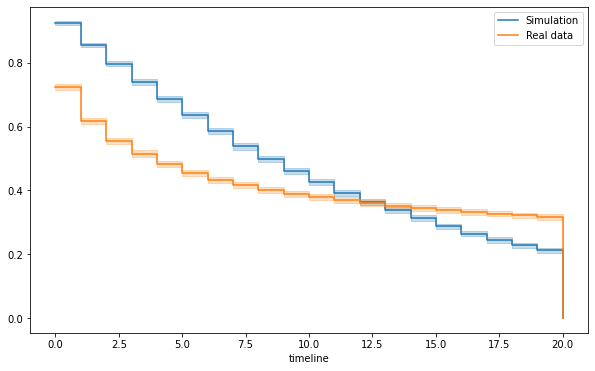

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
kmf = KaplanMeierFitter()
kmf.fit(durations = renewal_time_geom)
kmf.plot_survival_function(label='Simulation')
kmf.fit(durations = dat_expand['renewals'])
kmf.plot_survival_function(label='Real data')

### Test time stability of parameter p in time

In [ ]:
filt=2

In [ ]:
w_mean_estimator(dat_expand['renewals'][dat_expand['renewals']>=filt]-filt),prob_max_estimate(dat_expand['renewals'][dat_expand['renewals']>=filt]-filt, T-filt)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


(0.040670632774472686, 0.03900263295388988)

In [ ]:
w_mean_estimator(renewal_time_geom[renewal_time_geom>=filt]-filt),prob_max_estimate(renewal_time_geom[renewal_time_geom>=filt]-filt, T-filt)

(0.07436347268068604, 0.07258736539906543)

From the test above we can see that the model, as currently defined, is not enought to simulate real data. In particular the probability of unsubscription seems to be time dependent, differently from the sinthetic model.

In the provided data we observe a decreasing probability of unsubscription per time window as the observation period goes, while we built a simulation model that keeps the parameter p stable trought the T observations' time windows.